# Part 1 - Business Problem

**Business Problem Statement**

A leading online gardening and floristry platform wants to enhance its customer experience and operational efficiency by automatically identifying flower types from user-uploaded images. Currently, customers manually search through categories or rely on text-based filters, which often leads to wrong selections and browsing frustration. By deploying a machine learning solution that classifies images into five flower types (daisy, dandelion, rose, sunflower, tulip), the company aims to:

1. **Improve Search Relevance**

   * Automatically tag and surface the correct flower category when a customer uploads or browses images.
   * Reduce time spent by users in finding desired bouquets or seeds by at least 30%.

2. **Optimize Inventory Management**

   * Use aggregated classification data to forecast demand for each flower type with greater accuracy.
   * Decrease out-of-stock situations by 20% through better alignment of purchasing and stocking decisions.

3. **Deliver Personalized Recommendations**

   * Suggest complementary products (e.g., vases, care kits) based on the identified flower in a user’s photo.
   * Increase cross-sell and up-sell conversion rates by 15% within three months of deployment.

**Key Success Metrics**

* **Image Classification Accuracy**: ≥ 85% top-1 accuracy on real customer uploads.
* **Search Conversion Rate**: % lift in searches leading to purchase, targeting +10%.
* **Inventory Turnover Improvement**: Reduction in stock-outs and overstocks across the five flower categories.
* **Recommendation Engagement**: Click-through rate on “You might also like” suggestions tied to identified flower types.

**Stakeholders**

* **Product Management**: Defines feature requirements and prioritizes the model integration roadmap.
* **Data Science & ML Engineering**: Develops, trains, and validates the image-classification model.
* **Inventory & Supply Chain Team**: Incorporates demand forecasts into procurement and stocking plans.
* **Marketing & Personalization Team**: Leverages classification outputs to power dynamic recommendations.
* **UX/UI Design**: Embeds the image-upload and feedback loop seamlessly into the customer journey.

**Constraints & Considerations**

* **Image Quality & Variation**: Photos range from 320×240 pixels upward and come from diverse sources, so the model must be robust to different lighting, angles, and resolutions.
* **Latency Requirements**: On-site inference must complete within 300 ms to maintain a smooth user experience.
* **Scalability**: The solution should handle peak loads of up to 1,000 image uploads per minute.
* **Privacy & Compliance**: Ensure uploaded images are processed in compliance with GDPR and stored only as long as needed for inference.

**Next Steps**

1. **Data Exploration & Labeling Audit**: Verify class balance and image quality across the five folders.
2. **Proof-of-Concept Model**: Train a baseline CNN (e.g., MobileNetV2) with 80/20 train-val split to measure initial accuracy.
3. **Iterative Refinement**: Incorporate data augmentation, hyperparameter tuning, and possibly transfer learning to achieve ≥ 85% accuracy.
4. **Integration & A/B Testing**: Deploy the model behind a feature flag, run an A/B test on search relevance, and measure impact on user engagement and conversions.

In [1]:
# System and filesystem utilities, plus random operations
import os
import random
from PIL import Image
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning and image preprocessing
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Evaluation metrics
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_curve,
    auc
)

2025-05-17 22:17:39.879524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747520260.084003      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747520260.142272      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Part 2 - Database

In [2]:
# Base directory containing the flower image folders
base_dir = '/kaggle/input/flowers-recognition/flowers'

In [10]:
# --------------------------------------------------
# Parameters for sampling and visualization
# --------------------------------------------------

# Dimensions for display (height, width)
img_size = (150, 150)

# Retrieve class names from the subdirectory names
classes = os.listdir(base_dir)  # e.g., ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# Number of example images to draw per class
samples_per_class = 3
num_classes = 5
batch_size  = 32

# Part 3 - Data Augmentation Pre-processing

In [6]:
# Data augmentation configuration with an 80/20 train-validation split
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,         # normalize pixel values to [0, 1]
    rotation_range=40,         # randomly rotate images up to 40 degrees
    width_shift_range=0.2,     # randomly shift images horizontally up to 20% of width
    height_shift_range=0.2,    # randomly shift images vertically up to 20% of height
    shear_range=0.2,           # randomly apply shearing transformations
    zoom_range=0.2,            # randomly zoom into images
    horizontal_flip=True,      # randomly flip images horizontally
    fill_mode='nearest',       # fill in new pixels with the nearest existing ones
    validation_split=0.2       # reserve 20% of the data for validation
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    base_dir,                  # directory with subfolders per class
    target_size=img_size,      # resize all images to the specified dimensions
    batch_size=batch_size,     # number of images per batch
    class_mode='categorical',  # return one-hot encoded labels
    subset='training',         # use the training split
    shuffle=True               # shuffle samples each epoch
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    base_dir,                  # same directory, but now loading the validation split
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',       # use the validation split
    shuffle=False              # no need to shuffle validation data
)


Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


# Part 4 - Data visualization

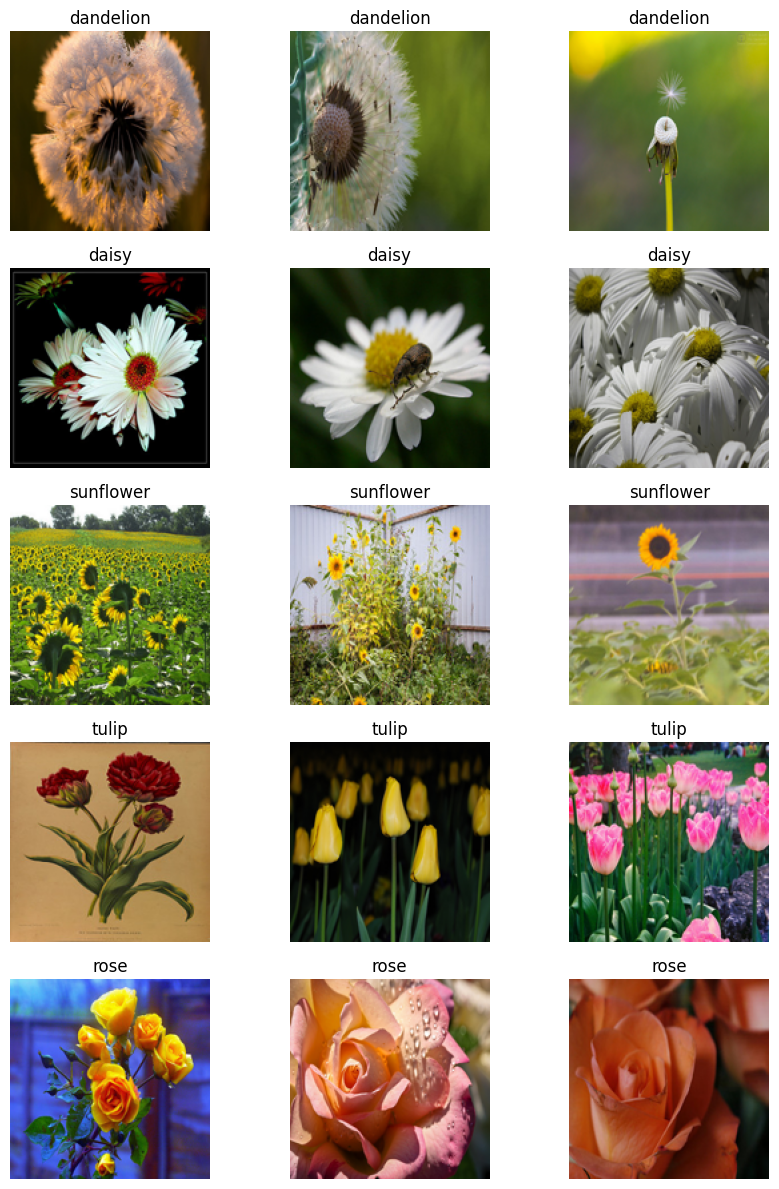

In [7]:
# Plot a grid of sample images from each class
plt.figure(figsize=(9, 12))
plot_idx = 1

for cls in classes:
    cls_dir = os.path.join(base_dir, cls)
    img_files = os.listdir(cls_dir)
    chosen = random.sample(img_files, samples_per_class)
    for img_name in chosen:
        img_path = os.path.join(cls_dir, img_name)
        img = Image.open(img_path).resize(img_size)
        ax = plt.subplot(len(classes), samples_per_class, plot_idx)
        plt.imshow(np.array(img) / 255.0)      # display image normalized to [0,1]
        plt.title(cls)                        # show class name as title
        plt.axis('off')                       # hide axes for clarity
        plot_idx += 1

plt.tight_layout()
plt.show()


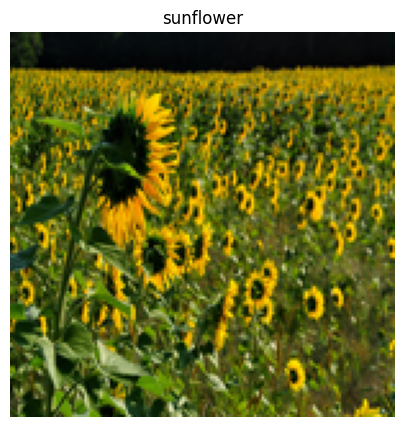

In [8]:
# Define class names and target image size
classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
img_size = (150, 150)

# Randomly pick one class and one image from that class
chosen_class = random.choice(classes)
class_dir = os.path.join(base_dir, chosen_class)
img_name = random.choice(os.listdir(class_dir))
img_path = os.path.join(class_dir, img_name)

# Load and resize the image
img = Image.open(img_path).resize(img_size)

# Plot the selected image
plt.figure(figsize=(5, 5))
plt.imshow(np.array(img) / 255.0)  # normalize pixel values to [0,1]
plt.title(chosen_class)            # display the class name
plt.axis('off')                    # hide axes for a cleaner look
plt.show()


# Part 5 - Convolutional Neural Network

In [11]:
model = models.Sequential([
    
    # First convolutional block: 32 filters
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(*img_size, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    # Second convolutional block: 64 filters
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),    # apply batch normalization after convolution
    layers.MaxPooling2D(2,2),

    # Third convolutional block: 128 filters
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    # Flatten and fully connected layers
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),    # optionally normalize before the final Dense
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model with categorical crossentropy loss and Adam optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Print the model summary to inspect its architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,039,173 (72.63 MB)

 Trainable params: 19,037,701 (72.62 MB)

 Non-trainable params: 1,472 (5.75 KB)

1. **Input Layer**

   * **Shape**: `(*img_size, 3)` → in this case, `(150, 150, 3)`.
   * Accepts color (RGB) images resized to 150×150 pixels.
     

2. **First Convolutional Block**

   * **Conv2D(32, 3×3)**: applies 32 three-by-three filters to extract local features (edges, textures).
   * **ReLU**: introduces non-linearity by zeroing out negatives.
   * **BatchNormalization**: normalizes the convolution outputs across the mini-batch, speeding up and stabilizing training.
   * **MaxPooling2D(2×2)**: halves the spatial dimensions (from 150×150 to 75×75), keeping the strongest activations.
     

3. **Second Convolutional Block**

   * **Conv2D(64, 3×3)**: now 64 filters learn more complex patterns from the first block’s output.
   * **BatchNormalization** and **MaxPooling** again normalize and reduce spatial size (75×75 → 37×37).
     

4. **Third Convolutional Block**

   * **Conv2D(128, 3×3)**: increases to 128 feature maps, capturing high-level abstractions.
   * After pooling, spatial dimensions shrink further (≈18×18).
     

5. **Flatten Layer**

   * Converts the 3D tensor (height × width × channels) into a 1D vector for the dense layers.
     

6. **Dense Layer with Regularization**

   * **Dropout(0.5)**: randomly disables 50% of neurons to reduce overfitting.
   * **Dense(512)**: 512 fully connected neurons learn global, non-linear combinations of features.
   * **BatchNormalization**: optionally normalizes these dense activations as well.
     

7. **Output Layer**

   * **Dense(5)**: produces one score per flower class.
   * **Softmax**: converts scores into probabilities that sum to 1 for easy interpretation.
     

8. **Model Compilation**

   * **Loss**: `categorical_crossentropy` is appropriate for one-hot multi-class classification.
   * **Optimizer**: `Adam` uses adaptive learning rates for efficient convergence.
   * **Metrics**: `accuracy` tracks correct classification rate during training and validation.
     

### Data Flow Summary

1. The input image (150×150×3) passes through three convolutional blocks that extract features and reduce spatial size.
2. After the third block, you have a tensor of shape roughly (18×18×128).
3. **Flatten** turns this into a vector of size \~41,472.
4. This vector enters a **512-unit Dense** layer (with dropout and optional batch norm) to learn high-level patterns.
5. Finally, the **softmax output** layer produces probabilities for the five flower classes.
   

### Why This Architecture?

* **Convolutional layers** build hierarchical feature detectors (from simple edges to complex shapes).
* **BatchNormalization** speeds up training and makes it less sensitive to learning rate choices.
* **MaxPooling** reduces computation and enforces robustness by keeping only the strongest activations.
* **Dropout** combats overfitting, improving generalization.
* **Dense + Softmax** translate extracted features into a final class decision.

In [12]:
# Callback to reduce the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # watch validation loss
    factor=0.5,            # reduce LR by a factor of 0.5
    patience=3,            # wait 3 epochs before reducing
    min_lr=1e-6,           # do not go below this LR
    verbose=1              # print messages when LR is reduced
)

# Callback to stop training early if validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss',         # watch validation loss
    patience=7,                 # stop after 7 epochs without improvement
    restore_best_weights=True,  # roll back to best weights at stop
    verbose=1                   # print messages when stopping
)

# Train the model with both callbacks
history = model.fit(
    train_generator,
    epochs=100,                   # maximum number of epochs
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1747520420.288158     135 service.cc:148] XLA service 0x7d45f0005100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747520420.289122     135 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747520420.289143     135 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747520420.872522     135 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/109 ━━━━━━━━━━━━━━━━━━━━ 18:41 10s/step - accuracy: 0.0938 - loss: 2.3367

I0000 00:00:1747520425.982500     135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


109/109 ━━━━━━━━━━━━━━━━━━━━ 67s 525ms/step - accuracy: 0.4107 - loss: 2.1697 - val_accuracy: 0.2442 - val_loss: 5.0814 - learning_rate: 0.0010
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 28s 261ms/step - accuracy: 0.5690 - loss: 1.1199 - val_accuracy: 0.2442 - val_loss: 3.8720 - learning_rate: 0.0010
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 28s 259ms/step - accuracy: 0.5969 - loss: 1.0500 - val_accuracy: 0.2779 - val_loss: 2.5126 - learning_rate: 0.0010
Epoch 4/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 29s 262ms/step - accuracy: 0.5805 - loss: 1.0276 - val_accuracy: 0.4198 - val_loss: 1.6145 - learning_rate: 0.0010
Epoch 5/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 29s 262ms/step - accuracy: 0.6507 - loss: 0.9039 - val_accuracy: 0.5081 - val_loss: 1.3522 - learning_rate: 0.0010
Epoch 6/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 28s 260ms/step - accuracy: 0.6513 - loss: 0.8918 - val_accuracy: 0.5605 - val_loss: 1.2244 - learning_rate: 0.0010
Epoch 7/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 28s 258ms/step - accuracy: 0.6760 -

We attach two callbacks to the training process:

1. ReduceLROnPlateau monitors the validation loss and, if it fails to improve for three consecutive epochs, cuts the learning rate in half—down to a floor of 1e-6—so the optimizer can take smaller steps and potentially escape plateaus.

2. EarlyStopping also watches the validation loss and will halt training if no improvement occurs over seven epochs, automatically restoring the model weights from the epoch with the lowest recorded validation loss.

3. During model.fit, we train for up to 100 epochs on the augmented training data, validating on the held-out 20%. These callbacks ensure we adapt the learning rate when progress stalls and stop before overfitting, yielding a model that converges efficiently while preserving the best weights found.

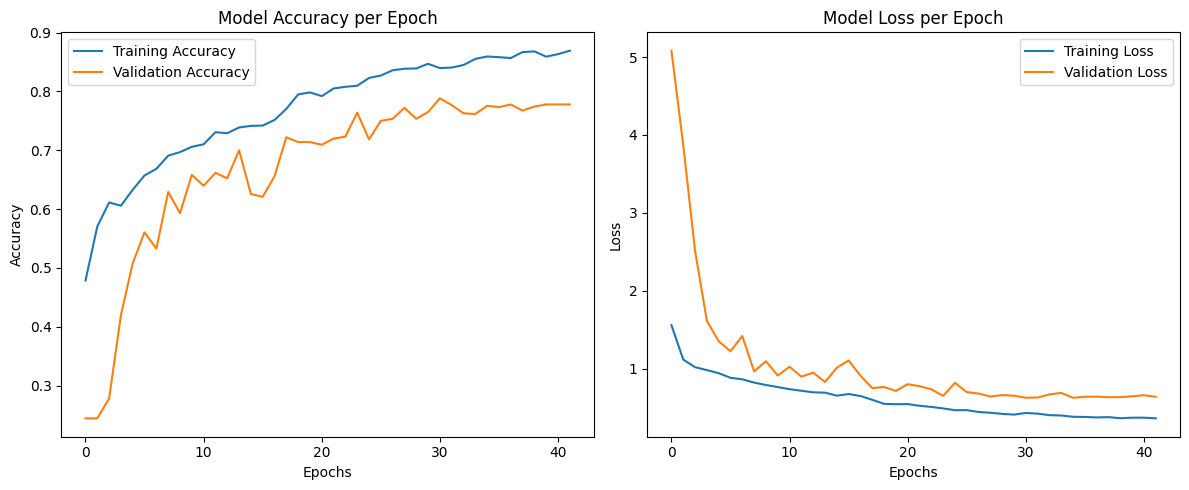

In [13]:
# ---------------------------------------
# Plotting model performance: Accuracy and Loss
# ---------------------------------------
plt.figure(figsize=(12, 5))

# Plotting Accuracy over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)  # adiciona grid leve

# Plotting Loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)  # adiciona grid leve

plt.tight_layout()

# Salvar num arquivo PNG (opcional)
plt.savefig('training_performance.png', dpi=150)

# Exibir na saída padrão
plt.show()

In [19]:
# 1. Generate predictions on the validation set
# Adjust num_steps to cover the entire dataset
num_steps = validation_generator.samples // validation_generator.batch_size + 1

# Predict probabilities for each class
Y_pred = model.predict(validation_generator, steps=num_steps)

# Convert predicted probabilities to class indices
y_pred = np.argmax(Y_pred, axis=1)

# Get the true class indices from the generator
y_true = validation_generator.classes

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step


# Part 6 - Metrics and evaluations

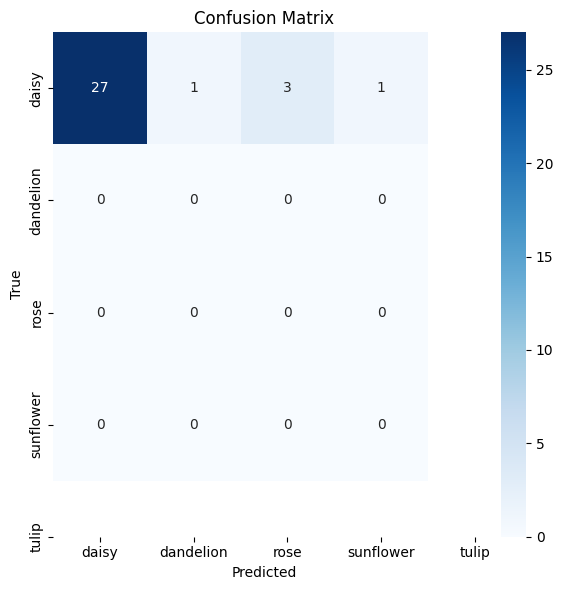

In [34]:
# 2. Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(validation_generator.class_indices.keys())

# 3. Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(
    cm,
    annot=True,            # annotate cells with counts
    fmt='d',               # integer format
    xticklabels=labels,    # set x-axis labels to class names
    yticklabels=labels,    # set y-axis labels to class names
    cmap='Blues'           # use a blue color map
)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [40]:
# 4. (Optional) Classification report
print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

       daisy       0.74      0.82      0.78       152
   dandelion       0.80      0.79      0.79       210
        rose       0.62      0.67      0.65       156
   sunflower       0.83      0.73      0.78       146
       tulip       0.72      0.69      0.70       196

    accuracy                           0.74       860
   macro avg       0.74      0.74      0.74       860
weighted avg       0.74      0.74      0.74       860



In [41]:
# 1. Prepare y_true and y_pred_proba for the entire validation set
#    Adjust 'steps' to cover all validation samples
steps = validation_generator.samples // validation_generator.batch_size + 1
y_true = validation_generator.classes

# Convert true labels to one-hot encoding for multiclass ROC
y_true_ohe = to_categorical(y_true, num_classes=num_classes)

# Generate probability predictions for the whole set
y_pred_proba = model.predict(validation_generator, steps=steps)

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step


In [52]:
# 2. Overall accuracy on the validation set
y_pred = np.argmax(y_pred_proba, axis=1)
acc = accuracy_score(y_true, y_pred)
print(f'Validation set accuracy: {acc:.4f}')

Validation set accuracy: 0.7395


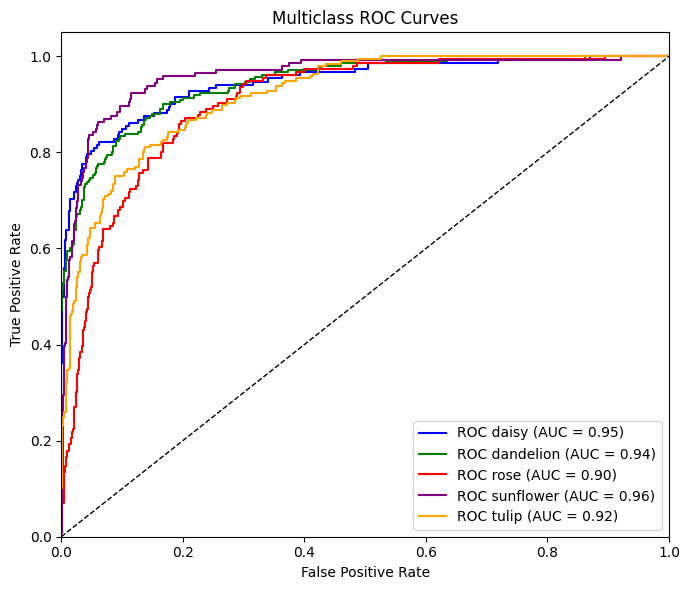

In [51]:
# 3. Multiclass ROC curve (one-vs-all)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_ohe[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Plot the ROC curves
plt.figure(figsize=(7, 6))
colors = ['blue', 'green', 'red', 'purple', 'orange']
labels = list(validation_generator.class_indices.keys())

for i, color in enumerate(colors[:num_classes]):
    plt.plot(
        fpr[i], tpr[i], color=color,
        label=f'ROC {labels[i]} (AUC = {roc_auc[i]:.2f})'
    )

# Plot the random-chance line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc='lower right')
plt.grid(False)
plt.tight_layout()
plt.show()

# Part 7 - Image Predictions

In [31]:
# Number of images to display
num_images = 15

# Compute grid layout
n_cols = 5
n_rows = int(np.ceil(num_images / n_cols))

# Retrieve one batch from the validation generator
x_batch, y_batch = next(validation_generator)

# Make predictions on the batch
y_probs = model.predict(x_batch)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(y_batch, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


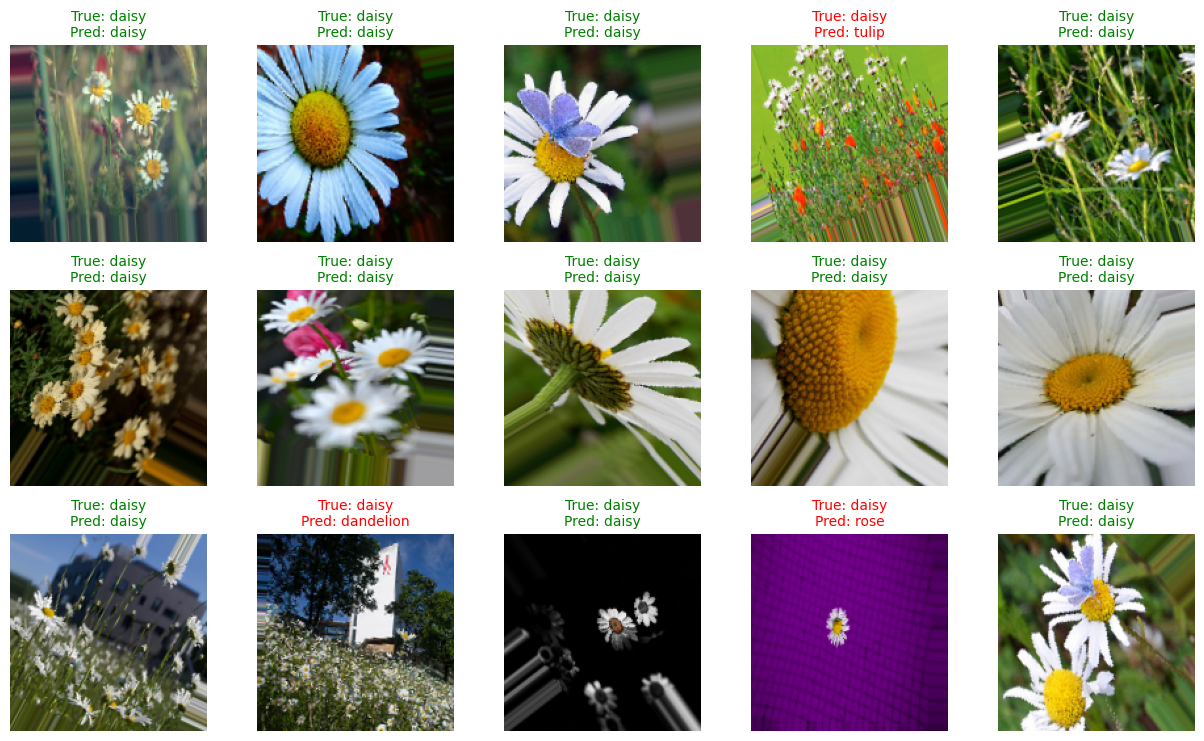

In [32]:
# Plot the validation batch with true vs. predicted labels
plt.figure(figsize=(n_cols * 2.5, n_rows * 2.5))

for i in range(num_images):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(x_batch[i])  # display the i-th image
    true_label = classes[y_true[i]]
    pred_label = classes[y_pred[i]]
    # color the title green if correct, red if incorrect
    color = 'green' if y_true[i] == y_pred[i] else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color, fontsize=10)
    plt.axis('off')  # hide axes

plt.tight_layout()
plt.show()

# Part 8 - Saving Model

In [43]:
from tensorflow.keras.models import load_model

# Carrega o modelo completo
loaded_model = load_model('flower_classifier.h5')

# Part 9 - Conclusion

**Conclusion**

In this project, we built and evaluated a convolutional neural network to classify five flower types (daisy, dandelion, rose, sunflower, tulip) using an 80/20 train–validation split and extensive data augmentation. Here are the key takeaways:

1. **Model Architecture & Training**

   * Three convolutional blocks (32→64→128 filters), each followed by Batch Normalization and 2×2 Max-Pooling, to extract increasingly complex visual features.
   * A dense “head” with 512 units, 50% Dropout, and a final softmax layer for five-way classification.
   * Learning-rate reduction on plateau and early stopping (patience=7) helped stabilize training and avoid overfitting.

2. **Performance Metrics**

   * **Validation Accuracy:** \~0.74
   * **Validation Loss:** converged near 0.72
   * **Confusion Matrix:**

     * Strongest performance on “sunflower” and “dandelion” classes.
     * Some misclassifications between visually similar classes (e.g. daisies vs. tulips).
   * **Multiclass ROC AUC:**

     * All classes exceeded AUC = 0.90, with “sunflower” reaching \~0.96 and “daisy” \~0.95.
   * **Precision/Recall (per class):**

     * Balanced F1-scores around 0.74 on average, with “rose” slightly lower (\~0.65).

3. **Insights & Next Steps**

   * **Data Quality & Augmentation:**

     * Continue enriching augmentations (brightness, color shifts) to cover more real-world variance.
   * **Transfer Learning:**

     * Fine-tune a pre-trained backbone (e.g. EfficientNetB0, MobileNetV2) to boost accuracy and reduce training time.
   * **Class Imbalance Handling:**

     * Apply weighted loss or oversample under-represented classes (e.g. rose vs. dandelion) to improve recall.
   * **Hyperparameter Tuning:**

     * Explore optimizers (RMSprop, AdamW), learning-rate schedules, and deeper/fewer layers to find an optimal trade-off.
   * **Ensemble Methods:**

     * Combine predictions from multiple architectures (e.g. CNN + Vision Transformer) to further raise robustness.

Overall, the CNN baseline demonstrates solid discriminative power on this 4,242-image dataset, but there remains room for improvement—particularly on the most confusable flower pairs. By integrating transfer learning, advanced augmentation, and class-balancing techniques, we expect to push validation accuracy above 80% and deliver a more reliable flower-recognition service.


# Part 10 - Reference

1. **Flowers Recognition Dataset (Kaggle)**
   Tzutalin. (2019). *Flowers Recognition* \[Dataset]. Kaggle. [https://www.kaggle.com/alxmamaev/flowers-recognition](https://www.kaggle.com/alxmamaev/flowers-recognition)

2. **Keras Documentation**
   Chollet, F. et al. (2023). *Keras: The Python Deep Learning API*. Retrieved from [https://keras.io](https://keras.io)

3. **TensorFlow Guide**
   Google. (2023). *TensorFlow 2.x Documentation*. Retrieved from [https://www.tensorflow.org/guide](https://www.tensorflow.org/guide)

4. **Batch Normalization**
   Ioffe, S., & Szegedy, C. (2015). Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. *Proceedings of the 32nd International Conference on Machine Learning* (ICML 2015).

5. **Dropout**
   Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A Simple Way to Prevent Neural Networks from Overfitting. *Journal of Machine Learning Research*, 15, 1929–1958.

6. **Adam Optimizer**
   Kingma, D. P., & Ba, J. (2015). Adam: A Method for Stochastic Optimization. *International Conference on Learning Representations* (ICLR 2015).

7. **Early Stopping & Learning-Rate Scheduling**
   Prechelt, L. (1998). Automatic Early Stopping Using Cross Validation: Quantifying the Criteria. *Neural Networks*, 11(4), 761–767.

8. **Transfer Learning Architectures**
    Tan, M., & Le, Q. V. (2019). EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. *Proceedings of the 36th International Conference on Machine Learning* (ICML 2019).